In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import platform

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV


# 운영체제별 한글 폰트 설정
if platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# Warning 제거
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.simplefilter(action='ignore', category=UserWarning)  
pd.set_option('mode.chained_assignment',  None)   
#pd.set_option('mode.chained_assignment', 'warn')

In [2]:
sample_df = pd.read_csv(r'data\sample_submission.csv')
test_df = pd.read_csv(r'data\test.csv')
train_df = pd.read_csv(r'data\train.csv')

In [3]:
Y = train_df['착과량(int)']
X = train_df.drop(['ID','착과량(int)'],axis = 1)
test = test_df.drop('ID',axis=1)

In [4]:
# import seaborn as sns

# corr = X.corr(method='pearson')
# plt.figure(figsize=(140,140))
# sns.heatmap(corr, annot=True, fmt='.1g')

In [5]:
cols=[]
for i in X.columns:
    if '엽록소' not in i:
        cols.append(i)
x = X[cols]
test = test_df[cols]

In [6]:
mean = x.mean(axis=0)
x -= mean
std = x.std(axis=0)
x /= std

test -= mean
test /= std

In [7]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(x.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [8]:
k = 4

num_val_samples = len(x) // k
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = x[i * num_val_samples: (i + 1) * num_val_samples]  #검증 데이터 준비: k번째 분할    
    val_targets = Y[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
        [x[:i * num_val_samples],
         x[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [Y[:i * num_val_samples],
         Y[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()  # 케라스 모델 구성(컴파일 포함)
    history = model.fit(partial_train_data, partial_train_targets,  # 모델 훈련(verbose=0이므로 훈련 과정이 출력되지 않습니다.)
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


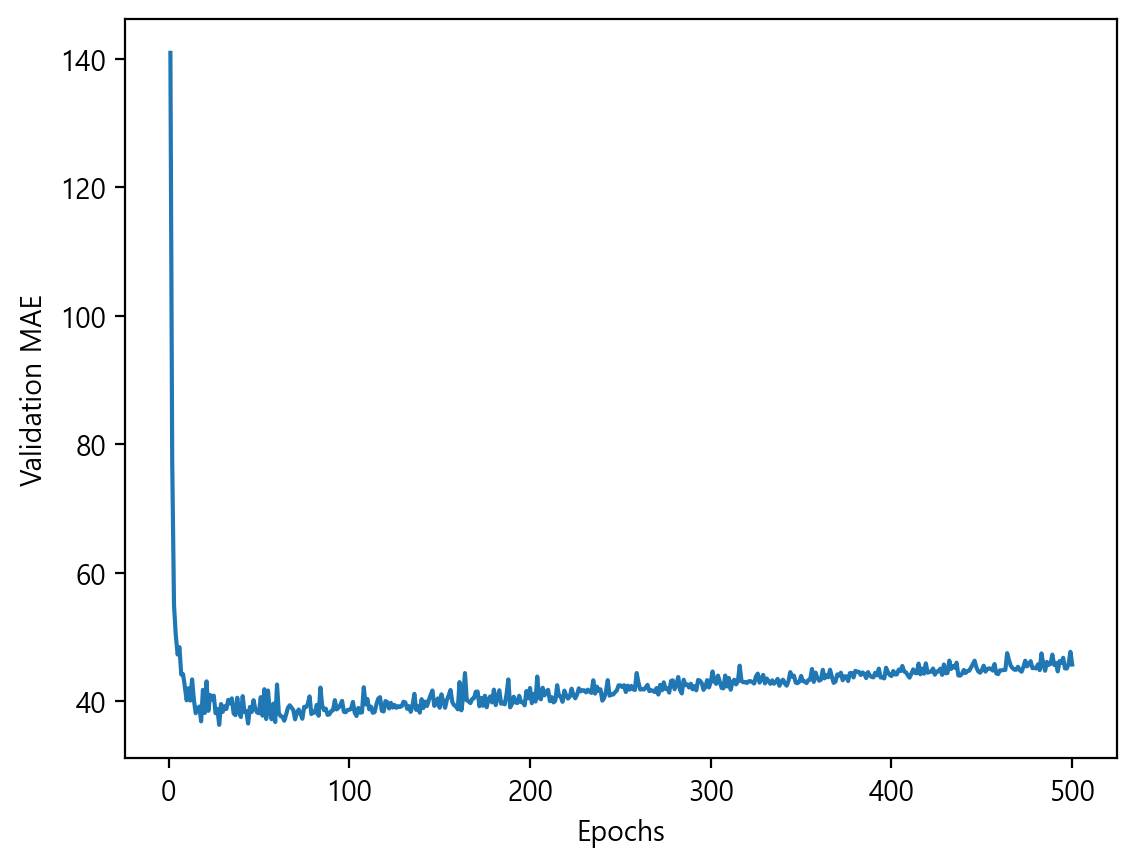

In [9]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

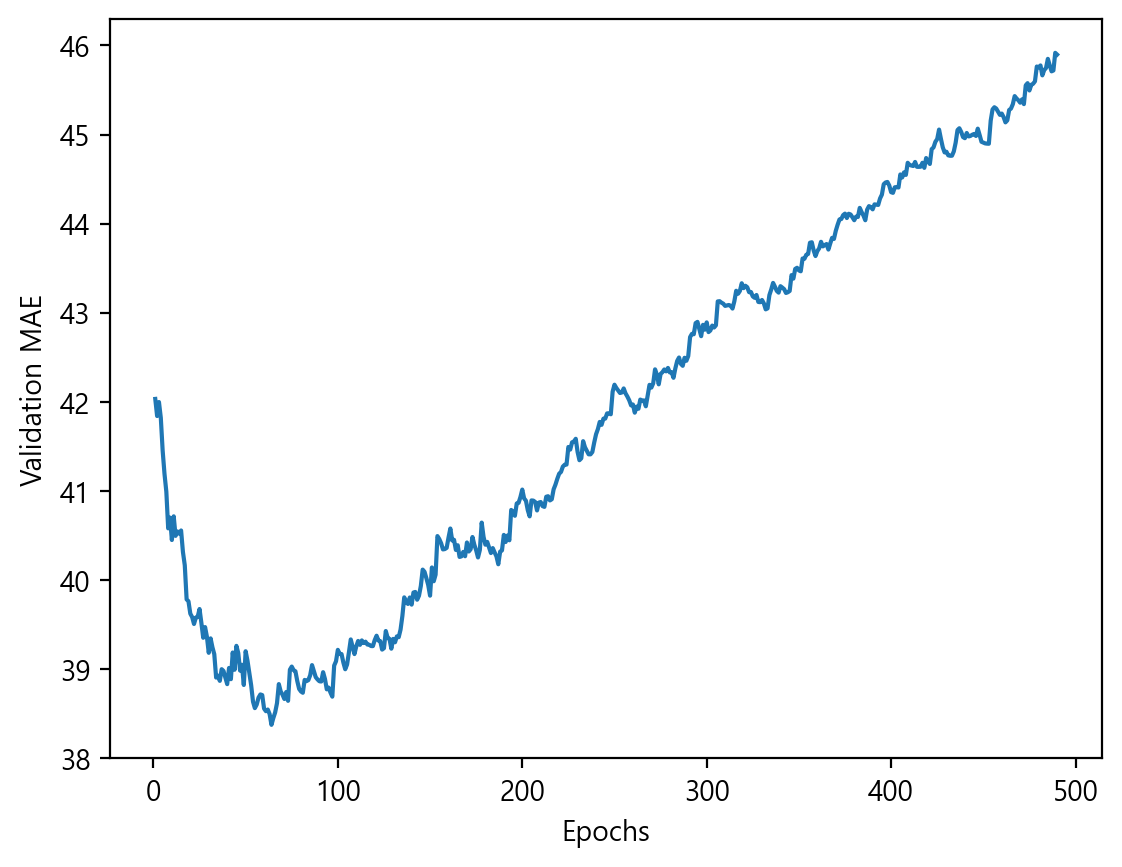

In [10]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [11]:
model= build_model()
model.fit(x,Y,epochs=70, batch_size=16 ,verbose=0)

test_pred = model.predict(test)
sample_df['착과량(int)'] = test_pred.astype(int)
sample_df.to_csv('result.csv',index=False)

69/69 [==============================] - 0s 560us/step
